In [46]:
using Pkg; Pkg.activate()

using NeymanScottProcesses
using Plots, LaTeXStrings

using LinearAlgebra: I
using Random: seed!

In [126]:
# ===
# SCRIPT PARAMETERS
# ===
num_trials = 50
num_parameters = 20

θ_arr = exp10.(range(0, 2, length=num_parameters))

# ===
# BASE MODEL PARAMETERS
# ===

dim = 2  # Dimension of the data
bounds = Tuple(1.0 for _ in 1:dim)  # Model bounds

K_base = 20.0  # Cluster rate
Ak_base = specify_gamma(20.0, 10.0^2)  # Cluster amplitude
A0 = specify_gamma(0.1, 0.1)  # Background amplitude

Ψ = 1e-3 * I(dim)  # Covariance scale
ν = 5.0  # Covariance degrees of freedom

5.0

In [127]:
seed!(070121)

num_cluster_results = zeros(num_parameters, num_trials)
num_datapoints_results = zeros(num_parameters, num_trials)

@time for trial in 1:num_trials
    for (ind, θ) in enumerate(θ_arr)
        # Change amplitude and cluster rate to approach DPM
        K = θ * K_base
        Ak = RateGamma(Ak_base.α / θ, Ak_base.β)

        # Create model and sample data
        priors =  GaussianPriors(K, Ak, A0, Ψ, ν)
        model = GaussianNeymanScottModel(bounds, priors; max_radius=max_cluster_radius)
        data, assignments, clusters = sample(model; resample_latents=true)
        
        # Store results
        num_cluster_results[ind, trial] = length(clusters)
        num_datapoints_results[ind, trial] = length(data)
    end
end

  2.585676 seconds (15.94 M allocations: 904.076 MiB, 11.20% gc time)


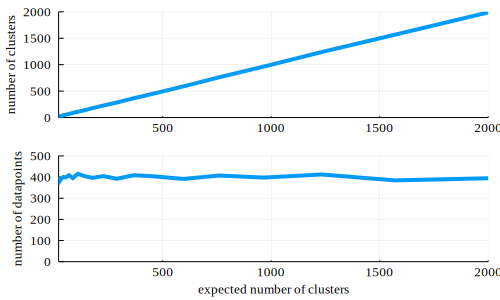

In [128]:
theme(:default, tickfont=(8, :Times), guidefont=(8, :Times), label=nothing, lw=4)
xlims = K_base .* (minimum(θ_arr), maximum(θ_arr))

plt1 = plot(K_base * θ_arr, mean(num_cluster_results, dims=2)[:, 1], ylims=(0, 2000), xlims=xlims)
plot!(ylabel="number of clusters")

plt2 = plot(K_base * θ_arr, mean(num_datapoints_results, dims=2), ylims=(0, 500), xlims=xlims)
plot!(ylabel="number of datapoints", xlabel="expected number of clusters")

plt = plot(plt1, plt2, layout=(2, 1), size=(500, 300))
savefig(plt, "../../figures/dpm_limit.pdf")
display(plt)

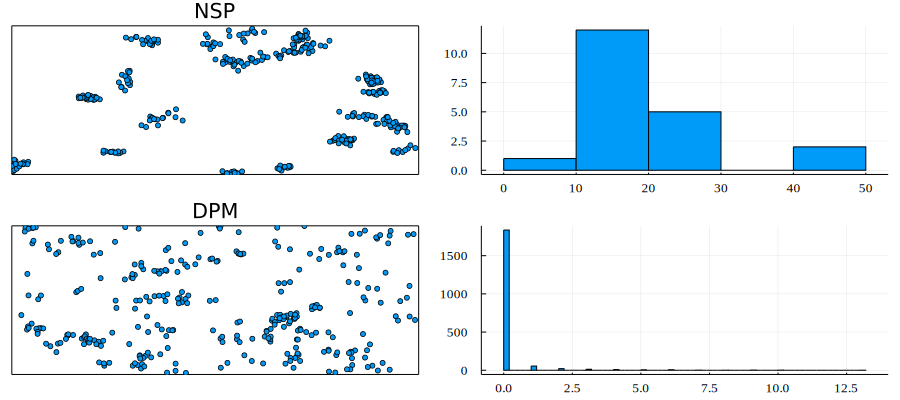

In [154]:
seed!(25876)

labels = ["NSP", "DPM"]

plts = []
for (i, θ_ind) in enumerate([1, length(θ_arr)])
    θ = θ_arr[θ_ind]

    # Change amplitude and cluster rate to approach DPM
    K = θ * K_base
    Ak = RateGamma(Ak_base.α / θ, Ak_base.β)

    # Create model and sample data
    priors =  GaussianPriors(K, Ak, A0, Ψ, ν)
    model = GaussianNeymanScottModel(bounds, priors; max_radius=max_cluster_radius)
    data, assignments, clusters = sample(model; resample_latents=true)

    xs = [pt.position[1] for pt in data]
    ys = [pt.position[2] for pt in data]

    plt1 = scatter(xs, ys, ms=3, xlims=(0, 1), ylims=(0, 1), xticks=nothing, 
        yticks=nothing, frame=:box, title=labels[i])
    plt2 = histogram([sum(==(k), assignments) for k in 1:length(clusters)], lw=1)
    push!(plts, plt1, plt2)
end
plt = plot(plts..., layout=(2, 2), size=(900, 400))
savefig(plt, "../../figures/dpm_vs_nsp.pdf")
display(plt)